# Exploitation - Edge Prediction

In the exploitation task, we aim to predict the edges. We start with Hand crafted features, followed by node embedding and finally use GNNs. In this notebook, we will work using the hand-crafted features.

## Task - 1

In the first task, we predict the edges between the given nodes only when considering a single route type.

### Hand-crafted features

For this task we consider the following node features

1. In degree centrality
2. Out degree centrality
3. Betweenness centrality
4. Katz centrality

and the following common features

1. fraction of common incoming neighbors among all incoming neighbors between the nodes
2. fraction of common outgoing neighbors among all outgoing neighbors between the nodes

To compute the edge features between nodes, we combine the node features by subtracting the source node features from the target node features and then add the edge features.

**Imports**


In [1]:
import glob
import pickle
import pathlib
import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns

from enum import Enum
from tqdm import tqdm
from typing import Union, List, Dict, Literal, Tuple
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, f_classif

**Paths for input and output**


In [2]:
rel_data_folder_path = pathlib.Path("./../../../data")
transport_data_path = rel_data_folder_path.joinpath("transport_data")
city_network = rel_data_folder_path.joinpath("network_graphs")
city_network_graphs = city_network.joinpath("graphs")
city_network_graphs_dir = city_network_graphs.joinpath("directed_graphs")
city_network_bones = city_network.joinpath("nodes-edges")

checkpoints_folder_path = rel_data_folder_path.joinpath("checkpoints")
city_network_graphs_dir_betweenness = checkpoints_folder_path.joinpath(
    "directed_graphs_betweenness"
)
city_network_graphs_dir_edge_pred_linreg = checkpoints_folder_path.joinpath(
    "linreg-single-class"
)
city_network_graphs_dir_edge_pred_linreg_hco = (
    city_network_graphs_dir_edge_pred_linreg.joinpath("handcraft_only")
)
city_network_graphs_dir_edge_pred_linreg_commono = (
    city_network_graphs_dir_edge_pred_linreg.joinpath("commonft_only")
)
city_network_graphs_dir_edge_pred_linreg_all = (
    city_network_graphs_dir_edge_pred_linreg.joinpath("both")
)

rel_docs_folder_path = pathlib.Path("./../../../documents")
reports_folder_path = rel_docs_folder_path.joinpath("report")
tex_folder_path = reports_folder_path.joinpath("tex_files")
images_folder_path = tex_folder_path.joinpath("images")

**Utility Functions**


In [8]:
# Define enum for route types
class RouteType(Enum):
    """
    An enumeration class representing different types of routes.

    Possible values:
    - tram
    - subway
    - rail
    - bus
    - ferry
    - cablecar
    - gondola
    """
    tram, subway, rail, bus, ferry, cablecar, gondola = range(7)

def load_city_graphs(city_name, graphs_folder):
    """
    Load the graph representation of a city from a file.

    Args:
        city_name (str): The name of the city.
        graphs_folder (pathlib.Path): The folder where the graph files are located.

    Returns:
        dict: A dictionary with key as the route type and value as the graph representation of the route network.
    """
    with open(graphs_folder.joinpath(city_name.lower() + '.gpickle'), 'rb') as f:
        city_graph = pickle.load(f)
    return city_graph

def load_all_cities_graphs(cities: list[str], graphs_folder: pathlib.Path):
    """
    Load the graph representations of multiple cities.

    Args:
        cities (list[str]): A list of city names.
        graphs_folder (pathlib.Path): The folder where the graph files are located.

    Returns:
        dict: A dictionary mapping city names to their dictionery of graph representations.
    """
    return {city: load_city_graphs(city, graphs_folder) for city in cities}


def generate_edge_feature_targets(
    graph: nx.Graph, incl_node_fts=True, incl_common_fts=True
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Generate a node feature matrix for a given graph.

    Args:
        graph: The input graph.
        incl_node_fts: Boolean to consider node features in creating the edge features
        incl_common_fts: Boolean to consider common outgoing and incoming neighbors) in creating the edge features

    Returns:
        edge_features: The edge features.
        targes: target vector with values of {0, 1}
        labels: vector of all possible targets in the graph

    """

    nodes = list(graph.nodes())
    num_nodes = len(nodes)

    edge_features = []
    targets = []

    if incl_node_fts:
        in_degree_centrality = nx.in_degree_centrality(graph)
        out_degree_centrality = nx.out_degree_centrality(graph)
        betweenness_centrality = nx.get_node_attributes(graph, "betweenness")
        katz_centrality = nx.katz_centrality(graph)

    for idx1 in range(num_nodes):
        node1 = nodes[idx1]
        # Get the incoming neighbors of the source node
        source_incoming = set(graph.predecessors(node1))
        # Get the outgoing neighbors of the source node
        source_outgoing = set(graph.successors(node1))
        node_1_feat = []
        if incl_node_fts:
            node_1_feat = [
                in_degree_centrality[node1],
                out_degree_centrality[node1],
                betweenness_centrality[node1],
                katz_centrality[node1],
            ]
        for idx2 in range(num_nodes):
            node2 = nodes[idx2]
            node_2_feat = []
            if incl_node_fts:
                node_2_feat = [
                    in_degree_centrality[node2],
                    out_degree_centrality[node2],
                    betweenness_centrality[node2],
                    katz_centrality[node2],
                ]

            edge_feature = np.subtract(node_2_feat, node_1_feat)

            if incl_common_fts:
                if idx1 == idx2:
                    frac_comm_incoming = 1
                    frac_comm_outgoing = 1
                else:
                    # Get the incoming neighbors of the target node
                    target_incoming = set(graph.predecessors(node2))

                    # Get the outgoing neighbors of the target node
                    target_outgoing = set(graph.successors(node2))

                    union_incoming = len(source_incoming.union(target_incoming))
                    union_outgoing = len(source_outgoing.union(target_outgoing))

                    if union_incoming == 0:
                        frac_comm_incoming = 0
                    else:
                        frac_comm_incoming = (
                            len(source_incoming.intersection(target_incoming))
                            / union_incoming
                        )

                    if union_outgoing == 0:
                        frac_comm_outgoing = 0
                    else:
                        frac_comm_outgoing = (
                            len(source_outgoing.intersection(target_outgoing))
                            / union_outgoing
                        )

                edge_feature = np.concatenate(
                    (edge_feature, np.array([frac_comm_incoming, frac_comm_outgoing]))
                )

            edge_features.append(edge_feature)
            targets.append(1 if graph.has_edge(node1, node2) else 0)

    return np.array(edge_features), np.array(targets), np.unique(targets)


def classifier(
    features: np.ndarray,
    targets: np.ndarray,
    labels: np.ndarray,
    feature_selection: bool = False,
    num_features: int = 1,
    test_size: float = 0.5,
    seed: int = 0,
    verbose: bool = False,
    input_feature_names: List[str] = [],
    title: str = "",
) -> Tuple[np.ndarray, float, float]:
    """
    INPUT:
    features: feature matrix of dimensions (N, D) (N: number of samples; D: number of features)
    targets: target vector of dimensions (N, ) (N: number of samples)
    labels: vector of all possible labels for nodes in the graph
    feature_selection: a flag for whether to use feature selction, bool
    num_features: number of features used from feature selection
    test_size: Size of the test set, float
    seed: please set to 0 for reproducibility
    verbose: print and plot result or not, bool
    input_feature_names: Names for the input features, None by default
    title: Title for the confusion matrix

    OUTPUT:
    cm: confusion matrix on the test set
    f1: weighted f1 score on the test set
    acc: accuracy score on the test set

    """

    # Split the data into training and testing sets, with test_size
    X_train, X_test, y_train, y_test = train_test_split(
        features, targets, stratify=targets, random_state=seed, test_size=test_size
    )

    if feature_selection:
        ## Build and train the ML model, including feature selection, normalization and Support Vector Classifier. Select the k highest relevant features for the classification.
        feature_selector = SelectKBest(f_classif, k=num_features)
        X_train_sel = feature_selector.fit_transform(X_train, y_train)
        clf = make_pipeline(
            StandardScaler(),
            LogisticRegression(class_weight="balanced", random_state=seed),
        )
        clf.fit(X_train_sel, y_train)
        ## Print the scores for individual features.
        print("\nTo select the top {} features:".format(num_features))
        if not input_feature_names:
            input_feature_names = [
                "feature_{}".format(str(i)) for i in range(features.shape[1])
            ]
        print("\tThe feature scorees are:")
        print(
            "\t{}".format(
                {
                    ft_name: ft_score
                    for ft_name, ft_score in zip(
                        input_feature_names, feature_selector.scores_
                    )
                }
            )
        )
        print(
            "\tThe selected features are {}".format(
                feature_selector.get_feature_names_out(
                    input_features=input_feature_names
                )
            )
        )
    else:
        ## Build and train the ML model, including normalization and Logi.
        clf = make_pipeline(
            StandardScaler(),
            LogisticRegression(class_weight="balanced", random_state=seed),
        )
        clf.fit(X_train, y_train)

    # Use the model to predict the labels of the test data
    if feature_selection:
        X_test_sel = feature_selector.transform(X_test)
        y_pred = clf.predict(X_test_sel)
    else:
        y_pred = clf.predict(X_test)
    # Output the confusion matrix and weighted f1 score on the test set. Print the weighted f1 score and plot the confusion matrix if verbose
    cm = metrics.confusion_matrix(y_test, y_pred, labels=labels)
    f1 = metrics.f1_score(y_test, y_pred, average="weighted")
    acc = metrics.accuracy_score(y_test, y_pred)

    if verbose:
        print("\t\tThe Weighted F1 score is {}".format(f1))
        print("\t\tThe Accuracy is {}".format(acc))
        disp = metrics.ConfusionMatrixDisplay(
            confusion_matrix=cm, display_labels=labels
        )
        disp.plot()
        if title:
            disp.ax_.set_title(title)
        plt.show()
    return cm, f1, acc  # type: ignore


def train_model(
    cities_graphs_dicts: Dict[str, Dict[str, Union[float, List[List[int]], nx.Graph]]],
    results_path: pathlib.Path,
    incl_node_fts: bool,
    incl_common_fts: bool,
    test_size: float,
    seed: int,
) -> None:
    """
    INPUT:
    cities_graphs_dicts: dictionary with keys as city names and values as dictionaries with keys as route types and values as route graphs
    results_path: path to save the results
    incl_node_fts: Boolean to consider node features in creating the edge features
    incl_common_fts: Boolean to consider common outgoing and incoming neighbors) in creating the edge features
    test_size: size of the test set, float
    seed: please set to 0 for reproducibility

    OUTPUT:
    None

    """

    results_path.mkdir(parents=True, exist_ok=True)

    for city, city_graphs in tqdm(cities_graphs_dicts.items()):
        city_graphs_scores = {}
        for route_type, route_graph in city_graphs.items():
            if (route_type in ["full"]) or (route_graph is None):
                city_graphs_scores[route_type] = {
                    "f1": None,
                    "cm": np.array([[0, 0], [0, 0]]),
                    "acc": None,
                }
                continue

            if (route_type in ["bus"]) and (city in ["sydney"]):
                city_graphs_scores[route_type] = {
                    "f1": None,
                    "cm": np.array([[0, 0], [0, 0]]),
                    "acc": None,
                }
                continue

            features_edges, targets_edge, labels_edge = generate_edge_feature_targets(
                route_graph,
                incl_node_fts=incl_node_fts,
                incl_common_fts=incl_common_fts,
            )

            cm, f1score, accuracy = classifier(
                features_edges,
                targets_edge,
                labels_edge,
                feature_selection=False,
                test_size=test_size,
                seed=seed,
                verbose=False,
            )

            city_graphs_scores[route_type] = {"f1": f1score, "cm": cm, "acc": accuracy}

        with open(results_path.joinpath("{}.gpickle".format(city)), "wb") as f:
            pickle.dump(city_graphs_scores, f, pickle.HIGHEST_PROTOCOL)

        print("Results saved")


def read_scores(
    results_path: pathlib.Path, modes_to_drop: List[str]
) -> Tuple[Dict[str, Dict[str, Union[float, list[List[int]], nx.Graph]]], pd.DataFrame]:
    cities_reg = sorted([x.stem for x in results_path.glob("*.gpickle")])
    cities_graphs_scores = load_all_cities_graphs(cities_reg, results_path)
    cities_graphs_scores_df = pd.DataFrame.from_dict(
        {
            (i, j): cities_graphs_scores[i][j]
            for i in cities_graphs_scores.keys()
            for j in cities_graphs_scores[i].keys()
        },
        orient="index",
    ).reset_index(drop=False, names=["city", "route"])

    if modes_to_drop:
        cities_graphs_scores_df = cities_graphs_scores_df[
            ~cities_graphs_scores_df["route"].isin(modes_to_drop)
        ]

    return cities_graphs_scores, cities_graphs_scores_df


def plot_cms(
    scores_dict: Dict[str, Dict[str, Union[float, List[List[int]], nx.Graph]]],
    mode: str,
) -> None:
    """
    Input
    scores_dict: dictionary with keys as city names and values as dictionaries with keys as metric name and values as metric
    mode: The mode of transport to use in the title
    """
    fig, axes = plt.subplots(5, 5, figsize=(16, 16), sharex=False, sharey=False)
    labels = [0, 1]
    for idx, (city, city_scores_lr) in tqdm(enumerate(scores_dict.items())):
        row = int(idx / 5)
        col = idx % 5

        cm = city_scores_lr[mode]["cm"]
        disp = metrics.ConfusionMatrixDisplay(
            confusion_matrix=cm, display_labels=labels
        )
        disp.plot(ax=axes[row][col], values_format="")
        disp.ax_.set_title(city)

    fig.suptitle(
        "Confusion Matrix for {} networks edge prediction (LogReg)".format(mode)
    )
    fig.tight_layout()


def plot_scores(
    scores_df: pd.DataFrame,
    score_string: Literal["f1", "acc"] = "f1",
    features: str = "all",
):
    """
    Input
    scores_df: Scores dataframe with columns city, route, and one column each for the F1 score, ConfusionMatrix and Accuracy
    score_string: The score string to plot.
    features: The features used to generate the scores
    """
    plt.figure(figsize=(12, 10))
    sns.scatterplot(data=scores_df, x="route", y=score_string, style="city", hue="city")
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1), ncol=1)
    plt.title(
        "{} score of edge prediction using {} features (LogReg)".format(
            score_string, features
        )
    )
    return plt.gcf()

**Setting the parameters**


In [4]:
seed = 0
test_size = 0.3

**Reading the graphs for all the cities**


In [5]:
cities = sorted([x.stem for x in city_network_graphs_dir.glob("*.gpickle")])
cities_graphs_dir = load_all_cities_graphs(cities, city_network_graphs_dir_betweenness)

## Modelling

Run the next cells to re run the training and save the accuracy, confusion matrix and the f1score. Otherwise, skip the next section and run the cell after it to load the saved scores.

We train a Logistic Regression model for each transport type in each city with 70:30 split of training and testing data while stratifying it based on the targets. The Sydney bus network is ignored as the memory is not sufficient for it.

We run three experiments in this part. First, we only use the node features i.e. In degree centrality, Out degree centrality, Betweenness centrality and Katz centrality. Second, only using the common incoming and outgoing neighbours features and lastly, using all 6 features.

### Only using Node features.


In [ ]:
train_model(
    cities_graphs_dir,
    city_network_graphs_dir_edge_pred_linreg_hco,
    incl_node_fts=True,
    incl_common_fts=False,
    test_size=test_size,
    seed=seed,
)

### Only using Common features.


In [ ]:
train_model(
    cities_graphs_dir,
    city_network_graphs_dir_edge_pred_linreg_commono,
    incl_node_fts=False,
    incl_common_fts=True,
    test_size=test_size,
    seed=seed,
)

### Using all features.


In [ ]:
train_model(
    cities_graphs_dir,
    city_network_graphs_dir_edge_pred_linreg_all,
    incl_node_fts=True,
    incl_common_fts=True,
    test_size=test_size,
    seed=seed,
)

## Results

- The results of cablecar are not inlcuded as there is only one city with three stops in that category.

### Only using Node features.


In [6]:
cities_graphs_scores_hco, cities_graphs_scores_hco_df = read_scores(
    city_network_graphs_dir_edge_pred_linreg_hco, modes_to_drop=["full", "cablecar"]
)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


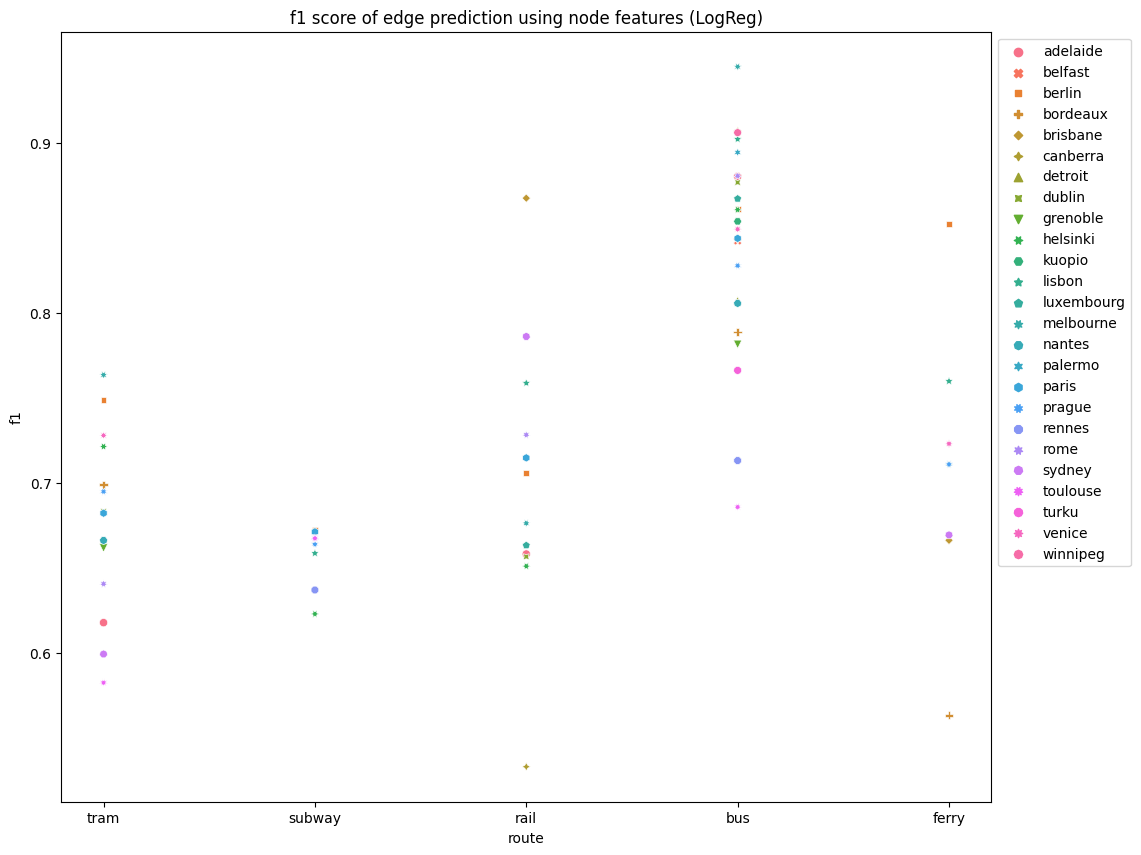

In [9]:
hco_fig = plot_scores(cities_graphs_scores_hco_df, features="node")

hco_fig.savefig(images_folder_path.joinpath('edge-pred-node.eps'), format='eps')

On using the node features alone for edge prediction,

#### Bus

The f1 scores for melbourne, canberara, winnipeg and lisbon are greater than 0.9 while for the other cities it is greater than 0.6. The accuracy for all the cities is greater than 0.5. We do not see any correlation between the f1 scores/accuracy and the graph properties.

#### Tram

All the 14 cities that have tram service have a f1 score greater than 0.5 and accuracies between 0.46 and 0.62.

#### Rail

In the 12 cities with Rail, the f1 score is between 0.53 and 0.86. No correlation with other graph properties.

#### Subway

The f1 score lies in the range of 0.62 and 0.67 for the subway network while the accuracy is in the 0.5 ball park.

#### Ferry

The f1 score for ferry is between 0.56 and 0.85 while the accuracy is between 0.53 and 0.9.


### Only using Common features.


In [10]:
cities_graphs_scores_commono, cities_graphs_scores_commono_df = read_scores(
    city_network_graphs_dir_edge_pred_linreg_commono, modes_to_drop=["full", "cablecar"]
)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


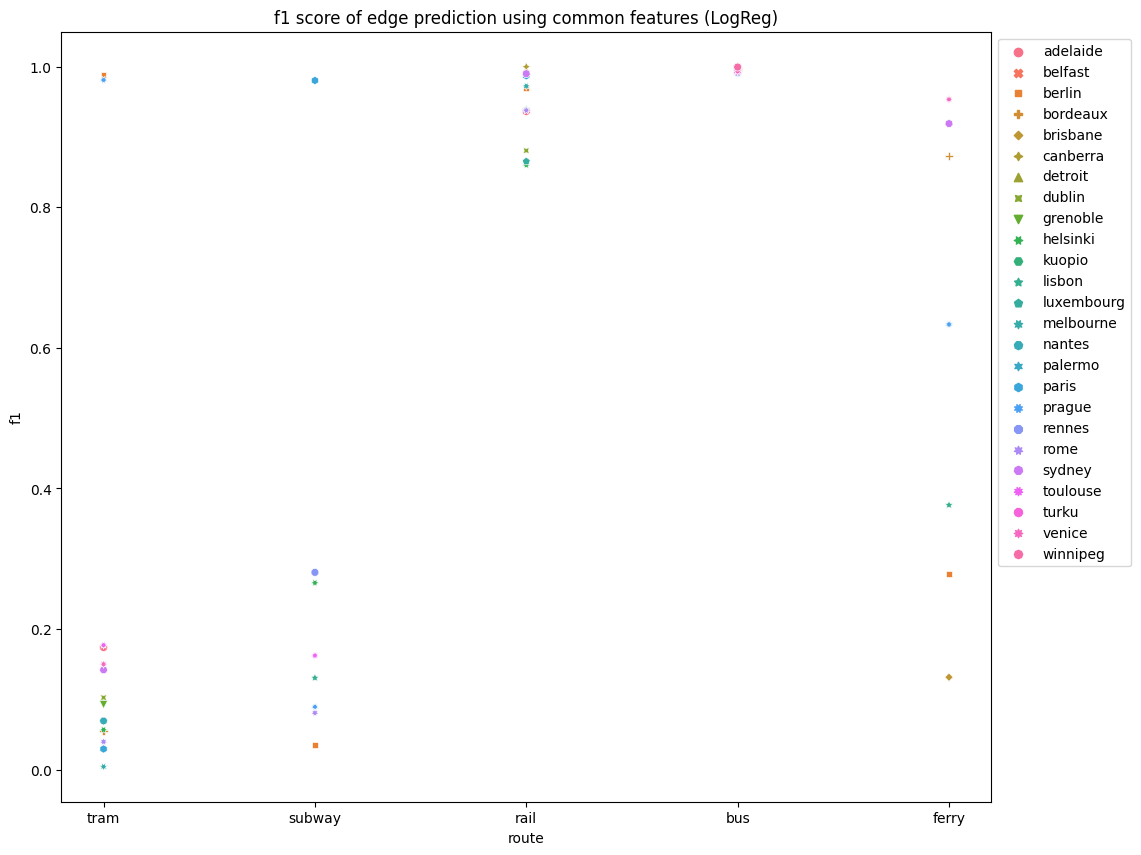

In [11]:
commono_fig = plot_scores(cities_graphs_scores_commono_df, features="common")

commono_fig.savefig(images_folder_path.joinpath('edge-pred-commono.eps'), format='eps')

On using the common incoming and outgoing node features alone for edge prediction,

#### Bus

The f1 scores for all cities is greater than 0.99. The accuracy for all the cities is greater than 0.98. The f1/accuracies are inversly propotional to the densities i.e, the graphs with high density have low f1/accuracy and those with low density have higher f1/accuracy. As we consider the jaccard coefficient of common incoming and outgoing neighbours between the nodes, the regressor is learning to predict an edge when the coefficients are 0 and 0. However, in denser networks and those netwoks that have more than one path to reach a node, the regressor is unable to perform well.

#### Tram

In the 14 cities that have tram service have a f1 score goes as low as 0.004 and as high as 0.988. There is no clear coorelation with any graph properties.

#### Rail

In the 12 cities with Rail, the f1 score is between 0.86 and 1.00. Canberra has f1 score of 1.0 but it only has 3 nodes with 4 edges. No correlation with other graph properties.

#### Subway

The f1 score lies in the range of 0.035 and 0.98 for the subway network. Three cities have the f1 score less than 0.1, four cities have it between 0.1 and 0.3 and one city greater than 0.9.

#### Ferry

The f1 score for ferry is between 0.13 and 0.95.


25it [00:00, 61.94it/s] 


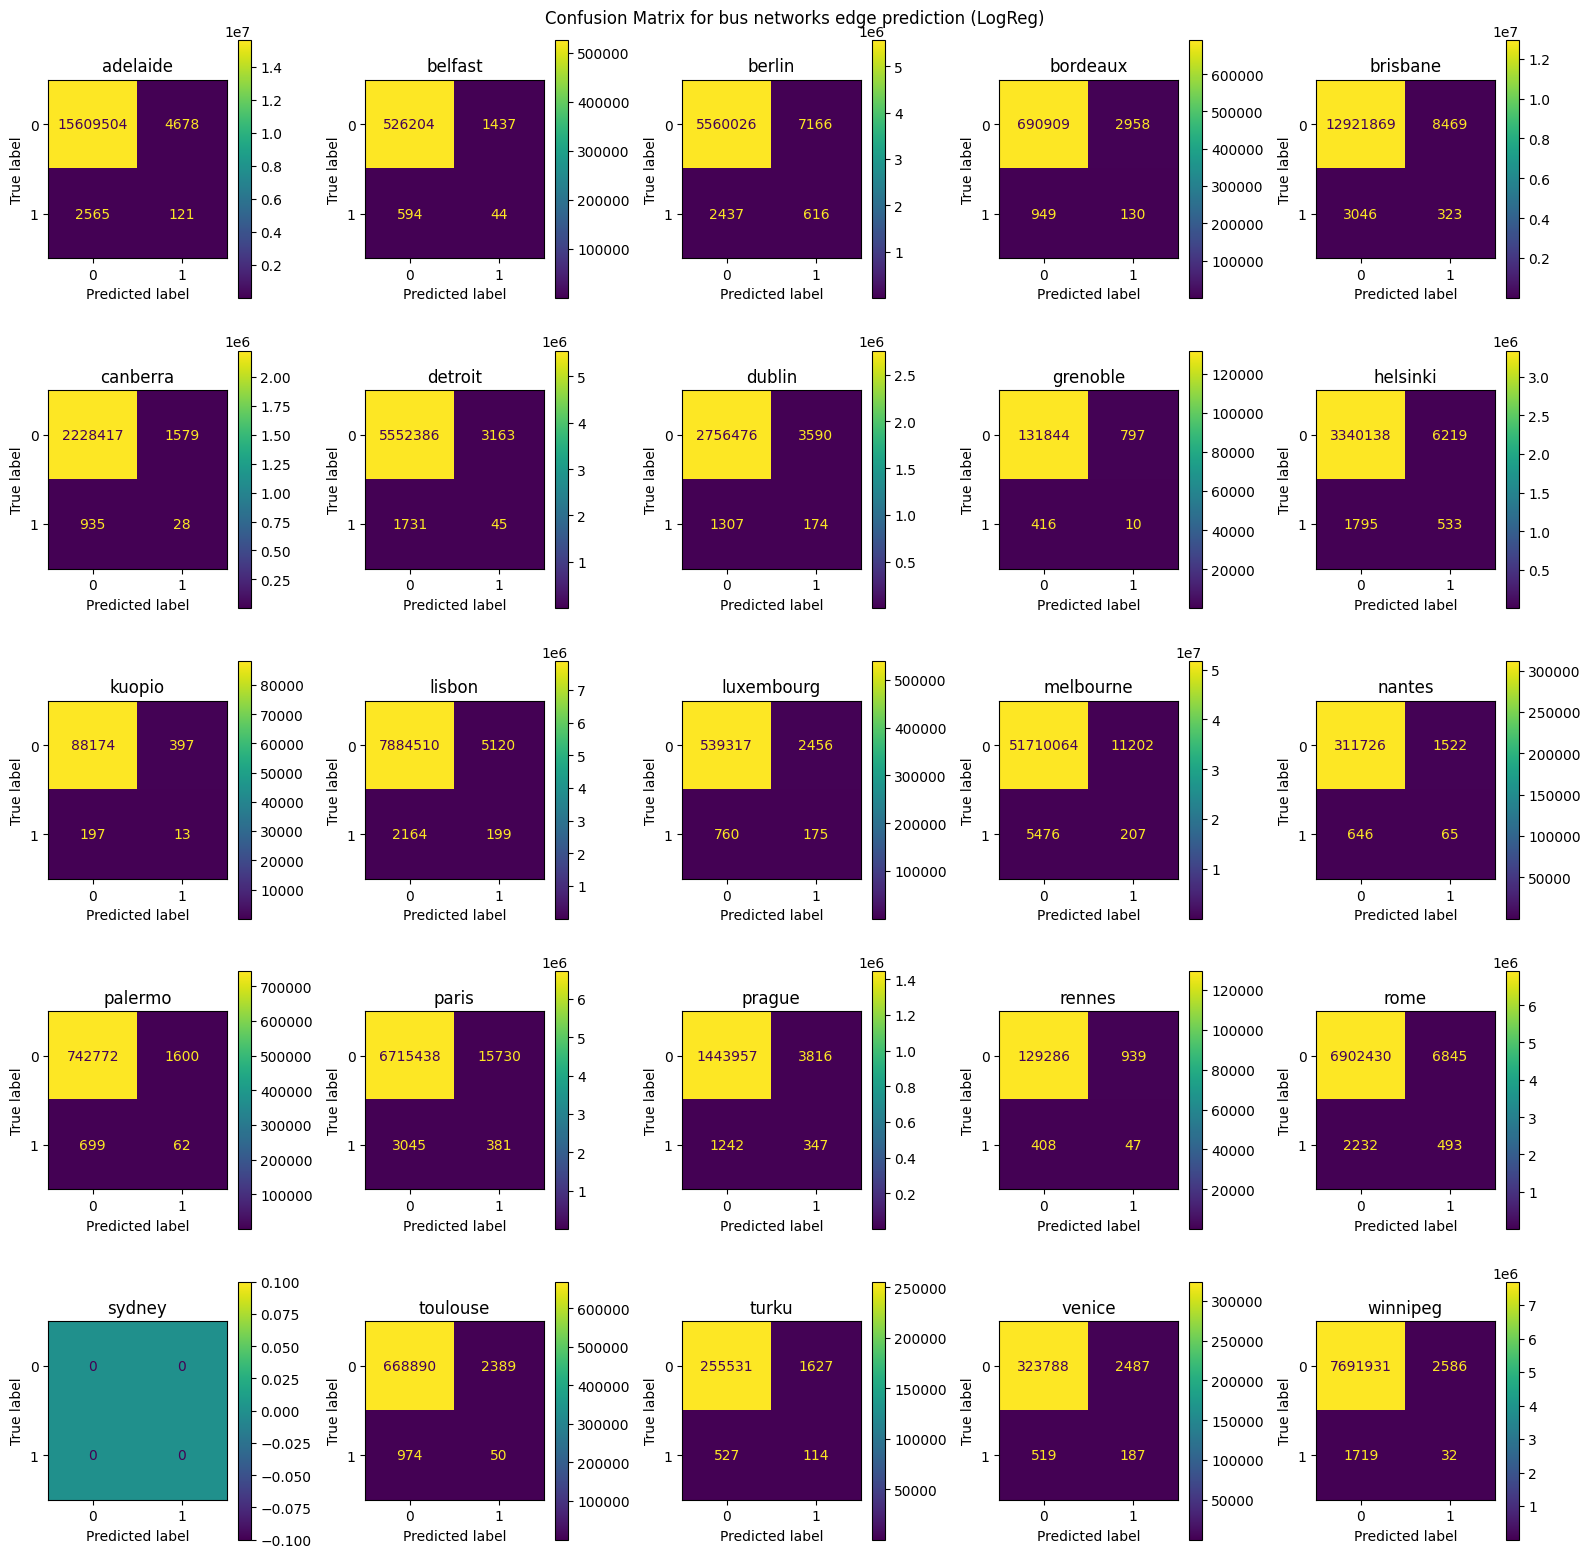

In [12]:
plot_cms(cities_graphs_scores_commono, mode="bus")

### Using all features.


In [13]:
cities_graphs_scores_all, cities_graphs_scores_all_df = read_scores(
    city_network_graphs_dir_edge_pred_linreg_all, modes_to_drop=["full", "cablecar"]
)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


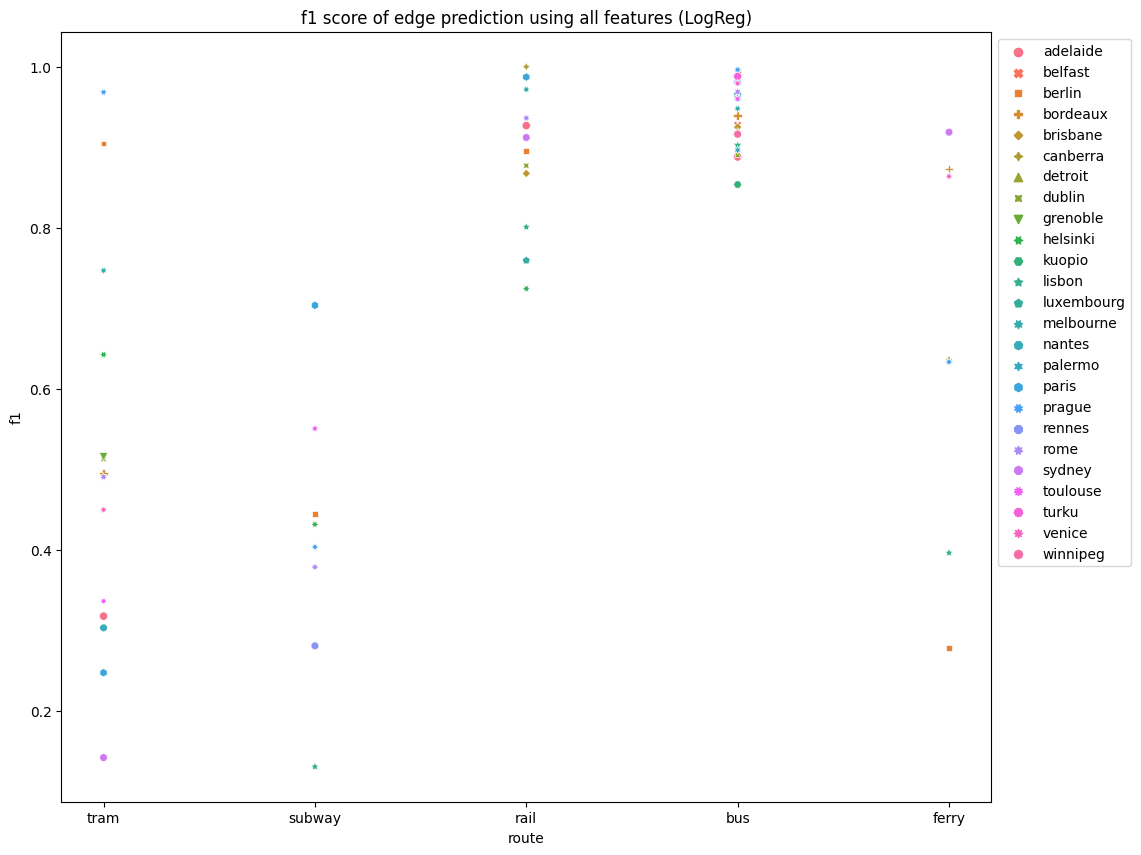

In [14]:
all_fig = plot_scores(cities_graphs_scores_all_df, features="all")

all_fig.savefig(images_folder_path.joinpath('edge-pred-all.eps'), format='eps')

On using the both node and common incoming and outgoing node features for edge prediction,

#### Bus

The f1 scores for all cities is greater than 0.85. The accuracy for all the cities is greater than 0.74. However, we do not see any direct correlation with the graph properties.

#### Tram

In the 14 cities that have tram service have a f1 score lies in the range of 0.14 and 0.96. There is no clear coorelation with any graph properties.

#### Rail

In the 12 cities with Rail, the f1 score is between 0.72 and 1.00. Canberra has f1 score of 1.0 but it only has 3 nodes with 4 edges. No correlation with other graph properties.

#### Subway

The f1 score lies in the range of 0.13 and 0.70 for the subway network.

#### Ferry

The f1 score for ferry is between 0.27 and 0.91.


In [15]:
combined_result_df = pd.merge(
    pd.merge(
        cities_graphs_scores_hco_df,
        cities_graphs_scores_commono_df,
        on=["city", "route"],
        suffixes=["_nodeo", "_commono"],
    ),
    cities_graphs_scores_all_df,
    on=["city", "route"],
)[["city", "route", "f1_nodeo", "f1_commono", "f1"]]
combined_result_df["best"] = combined_result_df[
    ["f1_nodeo", "f1_commono", "f1"]
].idxmax(axis=1)
combined_result_df["best_score"] = combined_result_df[
    ["f1_nodeo", "f1_commono", "f1"]
].max(axis=1)
combined_result_df[["city", "route", "best"]].pivot(
    index="city", columns="route", values="best"
)

route,bus,ferry,rail,subway,tram
city,,,,,
adelaide,f1_commono,NaN,f1_commono,NaN,f1_nodeo
belfast,f1_commono,NaN,NaN,NaN,NaN
berlin,f1_commono,f1_nodeo,f1_commono,f1_nodeo,f1_commono
bordeaux,f1_commono,f1_commono,NaN,NaN,f1_nodeo
brisbane,f1_commono,f1_nodeo,f1_commono,NaN,NaN
canberra,f1_commono,NaN,f1_commono,NaN,NaN
detroit,f1_commono,NaN,NaN,NaN,NaN
dublin,f1_commono,NaN,f1_commono,NaN,f1_nodeo
grenoble,f1_commono,NaN,NaN,NaN,f1_nodeo


In [16]:
combined_result_df[["city", "route", "best", "best_score"]].pivot(
    index="city", columns="route", values="best_score"
)

route,bus,ferry,rail,subway,tram
city,,,,,
adelaide,0.999602,NaN,0.936601,NaN,0.618054
belfast,0.996919,NaN,NaN,NaN,NaN
berlin,0.998652,0.852632,0.969793,0.672740,0.988677
bordeaux,0.995729,0.873016,NaN,NaN,0.699121
brisbane,0.999308,0.666461,0.992881,NaN,NaN
canberra,0.999014,NaN,1.000000,NaN,NaN
detroit,0.999246,NaN,NaN,NaN,NaN
dublin,0.998612,NaN,0.880687,NaN,0.683486
grenoble,0.992286,NaN,NaN,NaN,0.661960


For edge prediction on a individual mode of transport, the fraction of common incoming and outgoing neighbours are best suited for the bus and rail networks in all cities. Those featurs are also suitable for ferry network in Bordeaux, Sydney and Venice, Subway network in Paris and Tram network in Berlin and Prague. For the remaining citie in ferry, Subway and the tram vector, the chosen node features have performed. However, only in the cases where the common features suited well, the f1 score was greater than 0.87.
